# How much is this car worth?

**Goal**: Providing guideline for determining the starting negotiation price of used cars when posting and search in Craigslist

In [1]:
import pandas as pd
import numpy as np

import re
import matplotlib.pyplot as plt
import plotly_express as px
#import cufflinks as cf
from IPython.display import IFrame

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pprint import pprint


import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings("ignore")

#cf.set_config_file(offline=True)

#import plotly.offline as py
#py.init_notebook_mode(connected=False)
#pd.set_option('display.max_columns', 800)
#pd.set_option('display.expand_frame_repr', False)
#pd.set_option('max_colwidth', -1)

In [2]:
def pre_clean_df(raw_df):
    df=raw_df[['url', 'city', 'price', 'year', 'company', 'model', 'condition',
       'cylinders', 'fuel', 'mileage', 'title_status', 'transmission', 'drive',
       'size', 'type', 'paint_color']]
    
    df.dropna(subset=['company'], inplace=True)
    df.dropna(subset=['mileage'], inplace=True)
    
    brand_lst=['ford', 'chevrolet','toyota','honda','bmw','nissan','mercedes-benz','ram','jeep','gmc','dodge','volkswagen','lexus','hyundai',
    'subaru','audi','acura','kia','mazda','cadillac','chrysler','infiniti','volvo', 'mini', 'buick']
    df=df[df.company.str.contains('|'.join(brand_lst))]
    
    
    df.drop(df.loc[(df.year<1980)].index, axis=0, inplace=True)
    df.drop(df.loc[(df.price>90000)|(df.price<50)].index, axis=0, inplace=True)
    df.drop(df.loc[(df.year>2019)&(df.price<15000)].index, axis=0, inplace=True)
    df.drop(df.loc[(df.mileage>500000)].index, axis=0, inplace=True)
    df.drop(df.loc[(df.mileage<2000)&(df.year<2019)].index, axis=0, inplace=True)
    df.drop(df.loc[(df.company=='bmw')&(df.year<1990)&(df.price>50000)].index, axis=0, inplace=True)
    df.drop(df.loc[(df.mileage>900000)].index, axis=0, inplace=True)   
    
    df.reset_index(drop=True, inplace=True)
    return df

In [3]:
def df_stand(df):
    df['year'] = df['year'].apply(lambda x : (2020-x)/40)
    df['mileage'] = df['mileage'].apply(lambda x : (x-df['mileage'].mean())/df['mileage'].std())
    return df

In [4]:
def make_simple(df,col='model'):
   
    df[col]=df[col].fillna('null')
    df[col]=df[col].str.lower()
    df[col]=df[col].str.replace('-','', regex=True)
    df[col]=df[col].str.replace(' ','', regex=True)
    car_model=['silverado', 'f150', 'civic', 'accord', 'f250', 'camry', 'tacoma', 'corolla', 'wrangler',
              'sierra', 'prius', 'f350', 'altima', 'mustang', 'cherokee', 'x5', 'x3', 'tundra', 'fusion', 'focus',
               'tahoe', 'jetta', 'yukon', 'crv', 'explorer', 'sentra', 'cooper', 'escape', 'sienna', '328i', 'sonata',
               'rav4', 'odyssey', 'elantra', 'outback', 'suburban', 'a4', '4runner', 'camaro', 'cruze', 'e350', 
               'highlander', 'rogue', '3series', 'escalade', 'charger', 'impala', 'ranger', 'pilot', 'malibu',
               'challenger', 'forester', 'impreza', 'expedition', 'genesis','gti','cclass', 'corvette', 'frontier', 'colorado',
                'passat', 'mdx', 'optima', 'versa', 'sprinter', 'equinox', 'is250', 'is350','edge', 'grand caravan', 'eclass',
               'santafe', 'mazda3', 'durango', 'tsx', '5series','7series' 'f550', 'xc90', 'q5','soul', 'cruiser','wrx','golf', 'sorento', 
               'traverse', 'acadia', 'pathfinder', 'beetle', 'xterra', '1500', '2500', '3500']
    for i in car_model:
        df[col][df[col].str.contains(i)]=i
    df[col][df[col].apply(lambda x: x not in car_model)]='null'
    df['cylinders']=df['cylinders'].str.replace(' ','_', regex=True)
    df.drop(columns=['city','company', 'url'], inplace=True)
    return df

In [5]:
def get_dummy(df):
    dummy_col=df.select_dtypes('object').columns
    new_df=pd.get_dummies(df, columns=dummy_col, dummy_na=True,prefix=dummy_col)
    return new_df

In [6]:
def X_y_split(df):
    y=df.pop('price')
    X=df
    return X,y

In [7]:
def tt_split(X, y, test_size=.2):
    X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=test_size)
    return X_train, X_test, y_train, y_test

In [8]:
def df_ready(df):
    df1=pre_clean_df(df)
    X, y = X_y_split(df1)
    X_train1, X_test1, y_train, y_test= tt_split(X, y)
    
    X_train2=make_simple(X_train1)
    X_train3=get_dummy(X_train2)
    X_train=df_stand(X_train3)
    
    
    X_test2=make_simple(X_test1)
    X_test3=get_dummy(X_test2)
    X_test=df_stand(X_test3)
    
    return X_train, X_test, y_train, y_test

# Data acquisition

Data is obtained from the web scrapping of California craigslist site from June 21, 2019 to June 27, 2019 (7 Days).

In [9]:
raw_df=pd.read_csv('data/car_data_final.csv')

In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237347 entries, 0 to 237346
Data columns (total 16 columns):
url             237347 non-null object
city            237347 non-null object
price           237347 non-null int64
year            236994 non-null float64
company         223550 non-null object
model           231221 non-null object
condition       130062 non-null object
cylinders       139521 non-null object
fuel            236520 non-null object
mileage         191022 non-null float64
title_status    236114 non-null object
transmission    235256 non-null object
drive           164950 non-null object
size            77199 non-null object
type            176577 non-null object
paint_color     161160 non-null object
dtypes: float64(2), int64(1), object(13)
memory usage: 29.0+ MB


In [11]:
df=pre_clean_df(raw_df)

In [12]:
#px.scatter(df, x='year', y='price', title='Year Made vs Car price', color='company', template='plotly_dark')

In [13]:
#px.scatter(df, x='year', y='mileage',title='Year Made vs Mileage', color='company', template='plotly_dark')

In [14]:
#px.histogram(df, x='city', title='Number of data', template='plotly_dark')

In [15]:
#px.box(df, x='city', y='price', title='Car Price vs City', notched=True, template='plotly')

In [16]:
#px.histogram(df, x='price',nbins=150, title='Car Price', template='plotly_dark')

In [17]:
#px.histogram(df, x='company',title='Number of Cars per Company', template='plotly_dark').update_xaxes(categoryorder='total descending')

# OneHotEncoding and Train-Test-Split

In [18]:
X_train, X_test, y_train, y_test=df_ready(raw_df)

In [19]:
# print("----------------HEAD----------------\n")
# print(df.model.value_counts().head(10))
# print("\n----------------TAIL---------------\n")
# print(df.model.value_counts().tail(20))

# Train-Test-Split and Impute

# Decision Tree from Random Forest

In [20]:
rfr=RandomForestRegressor(max_depth=10, n_estimators=10)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [21]:
y_pred_rfr=rfr.predict(X_test)

In [22]:
#np.sqrt(mean_squared_error(y_test, y_pred_rfr))

In [23]:
rfr_fit = rfr.fit(X_train, y_train)
perm = PermutationImportance(rfr_fit).fit(X_test, y_test)
eli5.show_weights(perm)

Weight,Feature
0.4737 ± 0.0117,x0
0.2704 ± 0.0075,x1
0.1215 ± 0.0054,x128
0.1010 ± 0.0039,x110
0.0709 ± 0.0069,x107
0.0680 ± 0.0035,x127
0.0534 ± 0.0024,x104
0.0185 ± 0.0015,x145
0.0184 ± 0.0020,x106
0.0183 ± 0.0009,x130


In [24]:
DTFI=pd.DataFrame({'feature': X_test.columns.values})
DTFI['weight']=perm.feature_importances_
DTFI.sort_values(by='weight', ascending=False, inplace=True)

In [25]:
#DTFI.to_csv('Permutation_importance.csv', header=True)

In [26]:
DTFI.head(15)

,feature,weight
0,year,0.473685
1,mileage,0.270444
128,drive_fwd,0.121542
110,fuel_diesel,0.101004
107,cylinders_8_cylinders,0.070894
127,drive_4wd,0.067999
104,cylinders_4_cylinders,0.053428
145,type_sedan,0.018460
106,cylinders_6_cylinders,0.018356
130,drive_nan,0.018278


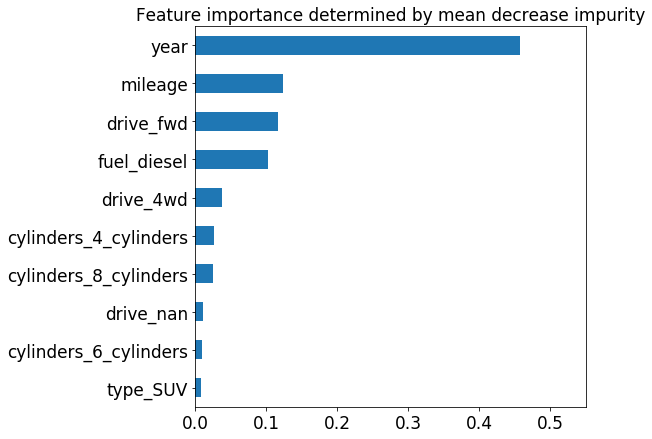

In [27]:
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rfr.feature_importances_},
                           index=X_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
ax=feat_scores.plot(kind='barh', figsize=(7,7), fontsize=17, legend=False)
ax.set_xlim(0,.55)
ax.set_ylim(152.5,162.5);
ax.set_title('Feature importance determined by mean decrease impurity', fontsize=17)
plt.savefig('img/MDI.png', bbox_inches='tight')

In [28]:
df=pre_clean_df(raw_df)

#px.scatter_3d(df, x='year', y='mileage', z='price', title= 'Year vs Mileage vs Price', color='company', hover_name='price',template='plotly_white', opacity=.5)

# Model Selection

In [29]:
imp_feat=['year', 'mileage', 'drive_fwd', 'fuel_diesel',
       'cylinders_8_cylinders', 'drive_4wd', 'cylinders_4_cylinders',
       'cylinders_6_cylinders', 'type_SUV', 'drive_nan', 'type_sedan',
       'type_pickup']

In [30]:
X_train_if=X_train[imp_feat]
X_test_if=X_test[imp_feat]

In [31]:
gb=GradientBoostingRegressor()
gb.fit(X_train_if, y_train)
gb_y_pred=gb.predict(X_test_if)
print('Important Features Only')
print('R2 of GB-model : {:2.2f}'.format(r2_score(y_test, gb_y_pred)))
print('test RMSE of GB-model : {:2.2f}'.format(np.sqrt(mean_squared_error(y_test, gb_y_pred))))

Important Features Only
R2 of GB-model : 0.68
test RMSE of GB-model : 6297.33


In [32]:
gb=GradientBoostingRegressor()
gb.fit(X_train, y_train)
gb_y_pred=gb.predict(X_test)
print('Total Features')
print('R2 of model : {:2.2f}'.format(r2_score(y_test, gb_y_pred)))
print('test RMSE of GB-model : {:2.2f}'.format(np.sqrt(mean_squared_error(y_test, gb_y_pred))))

Total Features
R2 of model : 0.70
test RMSE of GB-model : 6029.47


In [33]:
rf=RandomForestRegressor()
rf.fit(X_train_if, y_train)
rf_y_pred=rf.predict(X_test_if)
print('Important Features Only')
print('R2 of model : {:2.2f}'.format(r2_score(y_test, rf_y_pred)))
print('test RMSE of RF-model : {:2.2f}'.format(np.sqrt(mean_squared_error(y_test,rf_y_pred))))

Important Features Only
R2 of model : 0.67
test RMSE of RF-model : 6398.65


In [34]:
rf=RandomForestRegressor()
rf.fit(X_train, y_train)
rf_y_pred=rf.predict(X_test)
print('Total Features')
print('R2 of model : {:2.2f}'.format(r2_score(y_test, rf_y_pred)))
print('test RMSE of RF-model : {:2.2f}'.format(np.sqrt(mean_squared_error(y_test,rf_y_pred))))

Total Features
R2 of model : 0.86
test RMSE of RF-model : 4164.34


In [35]:
lr = LinearRegression().fit(X_train_if, y_train)
lr_y_pred=lr.predict(X_test_if)
print('Important Features Only')
print('R2 of model : {:2.2f}'.format(r2_score(y_test, lr_y_pred)))
print('test RMSE of LR-model : {:2.2f}'.format(np.sqrt(mean_squared_error(y_test,lr_y_pred))))

Important Features Only
R2 of model : 0.58
test RMSE of LR-model : 7224.77


In [36]:
lr = LinearRegression().fit(X_train, y_train)
lr_y_pred=lr.predict(X_test)
print('Total Features')
print('R2 of model : {:2.2f}'.format(r2_score(y_test, lr_y_pred)))
print('test RMSE of LR-model : {:2.2f}'.format(np.sqrt(mean_squared_error(y_test,lr_y_pred))))

Total Features
R2 of model : 0.64
test RMSE of LR-model : 6649.80


In [37]:
# rf = RandomForestRegressor(random_state = 42)
# pprint(rf.get_params())

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [38]:
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [39]:
# rf = RandomForestRegressor()
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 106.2min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 434.1min finished
RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [40]:
#rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [41]:
# from sklearn.model_selection import GridSearchCV
# # Create the parameter grid based on the results of random search 
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# # Create a based model
# rf = RandomForestRegressor()
# # Instantiate the grid search model
# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)

In [42]:
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [45]:
rf = RandomForestRegressor(n_estimators= 2000,min_samples_split= 2,min_samples_leaf= 1,max_features='sqrt',
                           max_depth= 110,bootstrap= True)
rf.fit(X_train, y_train)

Best Params
R2 of model : 0.86
test RMSE of RF-model : 4164.34


In [46]:
rf_y_pred=rf.predict(X_test)
print('Best Params')
print('R2 of model : {:2.2f}'.format(r2_score(y_test, rf_y_pred)))
print('test RMSE of RF-model : {:2.2f}'.format(np.sqrt(mean_squared_error(y_test,rf_y_pred))))

Best Params
R2 of model : 0.89
test RMSE of RF-model : 3687.77


In [49]:
y=pd.concat([y_train, y_test], ignore_index=True)
y_base=np.ones(len(y_test))*y.median()
rmse_test=np.sqrt(mean_squared_error(y_test,rf_y_pred))
rmse_base=np.sqrt(mean_squared_error(y_test,y_base))
print('Base RMSE: {}'.format(rmse_base))
print('Error reduction (RMSE of predict/RMSE of base) : {:2.2f}'.format(rmse_test/rmse_base))

Base RMSE: 11358.225241643662
Error reduction (RMSE of predict/RMSE of base) : 0.32


In [74]:
residu=y_test-rf_y_pred

In [79]:
px.box(pd.DataFrame(residu), y='price', title='True Price-Predicted Price', notched=True, template='plotly')

# Gradient Boosting

In [ ]:
# n_esti=100  # previous setting: 500

In [ ]:
# gb=GradientBoostingRegressor(n_estimators=n_esti, learning_rate=0.1)
# gb.fit(X_train, y_train)

In [ ]:
# train_score = np.zeros(n_esti)
# for i, y_pred in enumerate(gb.staged_predict(X_train)):
#     train_score[i] = np.sqrt(mean_squared_error(y_train, y_pred))

# test_score = np.zeros(n_esti)
# for i, y_pred in enumerate(gb.staged_predict(X_test)):
#     test_score[i] = np.sqrt(mean_squared_error(y_test, y_pred))
    
# plt.plot(np.arange(n_esti) + 1, train_score,
#         label="Training Error")
# plt.plot(np.arange(n_esti) + 1, test_score,
#         label="Testing Error")
# plt.title("Training and Hold Out Error by Boosting Stages")
# plt.xlabel('Number of Boosting Stages', fontsize=14)
# plt.ylabel('RMSE', fontsize=14)
# plt.legend(loc="upper right")
# plt.ylim(0,12000)
# plt.savefig('img/RMSE_3000.png', bbox_inches='tight')

In [ ]:
# y=pd.concat([y_train, y_test], ignore_index=True)

In [ ]:
# y_train_pred=gb.predict(X_train)
# y_test_pred=gb.predict(X_test)
# y_base=np.ones(len(y_test))*y.median()

In [ ]:
# rmse_train=np.sqrt(gb.loss_(y_train, y_train_pred))
# rmse_test=np.sqrt(gb.loss_(y_test, y_test_pred))
# rmse_base=np.sqrt(gb.loss_(y_test, y_base))

In [ ]:
# print('RMSE of train : {:2.2f}'.format(rmse_train))
# print('RMSE of test : {:2.2f}'.format(rmse_test))
# print('RMSE of base : {:2.2f}'.format(rmse_base))
# print("Error reduction (RMSE of predict/RMSE of base) : {:2.2f}".format(rmse_test/rmse_base))

# Civic Case

In [ ]:
# index_civic=X_test[X_test.model_civic==True].index
# y_civic=y_test[index_civic]
# X_civic=X_test[X_test.model_civic==True]
# y_pred_civic=gb.predict(X_civic)

In [ ]:
# y_civic_median=np.ones(len(y_civic))*y_civic.median()

In [ ]:
# rmse_civic_pred=np.sqrt(gb.loss_(y_civic, y_pred_civic))

In [ ]:
# rmse_civic_base=np.sqrt(gb.loss_(y_civic, y_civic_median))

In [ ]:
# print('RMSE of test : {:2.2f}'.format(rmse_civic_pred))
# print('RMSE of base : {:2.2f}'.format(rmse_civic_base))
# print('Error reduction (RMSE of predict/RMSE of base) : {:2.2f}'.format(rmse_civic_pred/rmse_civic_base))

# Kelley Blue Book (KBB)

In [ ]:
# kbb_civic=np.zeros(X_test.shape[1])
# df_kbb_civic=pd.DataFrame(kbb_civic.reshape(1,-1), columns=X_test.columns)
# df_kbb_focus=pd.DataFrame(kbb_civic.reshape(1,-1), columns=X_test.columns)

In [ ]:
# df_kbb_civic['model_civic']=1
# df_kbb_civic['year']=(2020-2001)/40
# df_kbb_civic['mileage']=(161000-93453)/104729
# df_kbb_civic['paint_color_grey']=1
# df_kbb_civic['cylinders_4_cylinders']=1
# df_kbb_civic['fuel_gas']=1
# df_kbb_civic['type_sedan']=1
# df_kbb_civic['transmission_automatic']=1
# df_kbb_civic['drive_fwd']=1

In [ ]:
# print("'2001 Honda Civic EX Sedan'")
# print("Price posted in KBB by owner: $3,333")
# print("KBB typical listing price: $2,789")
# print("Suggested price by the model: ${:2.0f}".format(gb.predict(df_kbb_civic)[0]))

In [ ]:
# df_kbb_focus['model_focus']=1
# df_kbb_focus['year']=(2020-2016)/40
# df_kbb_focus['mileage']=(38532-93453)/104729
# df_kbb_focus['paint_color_white']=1
# df_kbb_focus['cylinders_4_cylinders']=1
# df_kbb_focus['fuel_gas']=1
# df_kbb_focus['transmission_automatic']=1
# df_kbb_focus['drive_fwd']=1

In [ ]:
# print("'2016 Ford Focus Hatchback'")
# print("Price posted in KBB by owner: $15,334")
# print("KBB typical listing price: $10,949")
# print("Suggested price by the model: ${:2.0f}".format(gb.predict(df_kbb_focus)[0]))

# Pickle

In [ ]:
# import pickle
# pickle.dump(gb, open("./model.pkl","wb"))

# Tensorflow 2.0

In [ ]:
# from tensorflow import keras
# from tensorflow.keras import layers

# print(tf.__version__)

In [ ]:
# def build_model():
#     model = keras.Sequential([
#     layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(1)
#     ])

#     optimizer = tf.keras.optimizers.RMSprop(0.001)

#     model.compile(loss='mse',
#                 optimizer=optimizer,
#                 metrics=['mae', 'mse'])
#     return model

In [ ]:
# model = build_model()

# model.summary()

In [ ]:
# class PrintDot(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs):
#         if epoch % 100 == 0: print('')
#         print('.', end='')

# EPOCHS = 1000

# history = model.fit(
#   X_train, y_train,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[PrintDot()])

In [ ]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

In [ ]:
# def plot_history(history):
#     hist = pd.DataFrame(history.history)
#     hist['epoch'] = history.epoch

#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Abs Error')
#     plt.plot(hist['epoch'], hist['mae'],
#            label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mae'],
#            label = 'Val Error')
#     plt.ylim([0,4500])
#     plt.legend()

#     plt.figure()
#     plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error')
#     plt.plot(hist['epoch'], hist['mse'],
#            label='Train Error')
#     plt.plot(hist['epoch'], hist['val_mse'],
#            label = 'Val Error')
#     plt.ylim([0,50000000])
#     plt.legend()
#     plt.show()


# plot_history(history)

In [ ]:
# loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)

# print("Testing set Mean Abs Error: {:5.2f}".format(mae))

In [ ]:
# test_predictions = model.predict(X_test).flatten()

# plt.scatter(y_test, test_predictions)
# plt.xlabel('True Values')
# plt.ylabel('Predictions')
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
# #_ = plt.plot([-100, 100000], [-100, 100000])